# gene expression, GO 5 tissue consistent

In [3]:
import subprocess
import os
import numpy as np
import pandas as pd
import matplotlib as mpl
mpl.rcParams['pdf.fonttype'] = 42
mpl.rcParams['ps.fonttype'] = 42
mpl.rcParams['font.sans-serif'] = 'Arial'
import matplotlib.pyplot as plt
import seaborn as sns
from pprint import pprint
from matplotlib.backends.backend_pdf import PdfPages
%matplotlib inline

In [5]:
# Python functions to read .CSV files into a Pandas DataFrame when the data of interest is before / after one or more empty/blank lines.
import csv
def csv_after_emptylines(filepath, dtype=str):
    """ Read a .CSV into a Pandas DataFrame, but only after at least one blank line has been skipped.
    bl_group_n is the expected number of distinct blocks of blank lines (of any number of rows each) to skip before reading data.
    NB: E.g. pd.read_csv(filepath, skiprows=[0, 1, 2]) works if you know the number of rows to be skipped. Use this function if you have a variable / unknown number of filled rows (to be skipped / ignored) before the empty rows.
    """
    with open(filepath, newline='') as f:
        contents = []
        headers = None
        r = csv.reader(f, delimiter='\t')
        return_df = pd.DataFrame()
        cluster_flag = True
        header_flag = False
        for i, l in enumerate(r):
            if not l:
                df = pd.DataFrame(data=contents, columns=headers, dtype=dtype)
                df['cluster'] = name[0].split(" ")[-1]
                df['enrichment_score'] = float(name[1].split(" ")[-1])
                return_df = pd.concat([return_df, df])
                contents = []
                cluster_flag = True
            else :
                if cluster_flag :
                    name = l
                    cluster_flag = False
                    header_flag = True
                elif header_flag :
                    headers = l
                    header_flag = False
                else :    
                    contents.append(l)
                
        df = pd.DataFrame(data=contents, columns=headers, dtype=dtype)
        df['cluster'] = name[0].split(" ")[-1]
        df['enrichment_score'] = float(name[1].split(" ")[-1])
        return_df = pd.concat([return_df, df])        
        
        return return_df


def csv_until_emptyline(filepath, dtype=str):
    """ Read a .CSV into a Pandas DataFrame until a blank line is found, then stop.
    """
    with open(filepath, newline='') as f:
        contents = []
        r = csv.reader(f, delimiter='\t')
        name = next(r, None)
        for i, l in enumerate(r):
            if not l:
                break
            if i == 0:
                headers = l
                continue
            contents.append(l)
        df = pd.DataFrame(data=contents, columns=headers, dtype=dtype)
        df['cluster'] = name[0].split(' ')[-1]
        df['enrichment_score'] = float(name[1].split(' ')[-1])
        return df

# Universal CHM, A/B compartments consistent

## target genes

In [7]:
%%bash
### intersect non-CHM CpG-rich 1kb-bin with A/B compartment
cd ~/CHMsInOtherContexts/CellStateTransition/CHMOrganization/Universal_specific/Features/ChromatinStates/Cavalli_Cell2017_ABcompartment_5tissue
mkdir -p nonCHM_intersect_table
bedtools intersect -wao -f 1 -a ~/CHMsInOtherContexts/CellStateTransition/CHMOrganization/Universal_specific/Sequence/NonCHMsCpGrich.bed -b AB_compartment_intersect_Cavalli_Cell2017.bed > nonCHM_intersect_table/intersectOnly_nonCHM_5tissue_AB.bed
for compart in A B;do
    awk -v compart1=${compart} 'BEGIN{FS=OFS="\t"} $7==compart1 && $8>0{print $1,$2,$3}' nonCHM_intersect_table/intersectOnly_nonCHM_5tissue_AB.bed > nonCHM_intersect_table/intersectOnly_nonCHM_5tissue_${compart}.bed  
done

In [10]:
%%bash
### universal CHM target genes
cd ~/CHMsInOtherContexts/CellStateTransition/CHMOrganization/Universal_specific/Features/ChromatinStates/Cavalli_Cell2017_ABcompartment_5tissue/CHM_intersect_table
mkdir -p targetGenes
for compart in A B;do
    for distance in 10 20 50 100 200 300;do
        mkdir -p targetGenes/within_${distance}kb
        windowBed -w ${distance}000 -a intersectOnly_UniversalCHM_5tissue_${compart}.bed -b ~/../yanghui/annotations/mm10/mm10.TSS.refGene.bed | cut -f 12 | sort -u > targetGenes/within_${distance}kb/UniversalCHM_${compart}.targetGenes_RefSeq.txt # 
    done
done

In [19]:
%%bash
### nonCHM target genes
cd ~/CHMsInOtherContexts/CellStateTransition/CHMOrganization/Universal_specific/Features/ChromatinStates/Cavalli_Cell2017_ABcompartment_5tissue/nonCHM_intersect_table
mkdir -p targetGenes
for compart in A B;do
    for distance in 10 20 50 100 200 300;do
        mkdir -p targetGenes/within_${distance}kb
        windowBed -w ${distance}000 -a intersectOnly_nonCHM_5tissue_${compart}.bed -b ~/../yanghui/annotations/mm10/mm10.TSS.refGene.bed | cut -f 7 | sort -u > targetGenes/within_${distance}kb/nonCHM_${compart}.targetGenes_RefSeq.txt # 
    done
done

In [21]:
### read in target genes as dict
target_gene_dict = {}
for t in ['UniversalCHM', 'nonCHM'] :
    target_gene_dict[t] = {}
    for distance in [10, 20, 50, 100, 100, 200, 300] :
        target_gene_dict[t][distance] = {}
        t_short = 'CHM' if t =='UniversalCHM' else t
        os.chdir(f'/mnt/Storage/home/wangyiman/CHMsInOtherContexts/CellStateTransition/CHMOrganization/Universal_specific/Features/ChromatinStates/Cavalli_Cell2017_ABcompartment_5tissue/{t_short}_intersect_table/targetGenes/within_{distance}kb')
        for compart in ['A', 'B'] :
            target_gene_dict[t][distance][compart] = pd.read_csv(f'{t}_{compart}.targetGenes_RefSeq.txt', header = None)[0].tolist()


## expression level

### merge TPM to expr_mat

In [318]:
# add cmd lines to runned.sh
run = True

if run == True :
    os.chdir('/mnt/Storage/home/wangyiman/CHMsInOtherContexts/CellStateTransition/CHMOrganization/Universal_specific/Features/TargetGenes/Expression')
    with open('/mnt/Storage/home/wangyiman/CHMsInOtherContexts/bin/make13_runned_mergeExpr.sh', 'w') as cmd_fi :
        cmd_fi.write('#!/bin/bash')
        for expression_type in ['FPKM', 'TPM'] :
            column = '12' if expression_type == 'FPKM' else '13'
            for finame in ['process_stage_replicate_gtf_loc.csv'] :
                with open(f'{finame}') as samplefi :
                    sample_ls = []
                    firstline = samplefi.readline()
                    gtffi = firstline.strip().split(',')[1]
                    cmd = 'paste' +f' <(gtf_to_table.py -l 9 -f transcript {gtffi} | grep -v ' + "'#'" +f' | cut -f 10,{column} | sort -k1,1 - )'
                    cmd2 = 'cat <(echo transcript_id' + "$'\\t'" + firstline.strip().split(",")[0]+"$'\\t'"

                    for line in samplefi :
                        gtffi = line.strip().split(',')[1]
                        cmd += f' <(gtf_to_table.py -l 9 -f transcript {gtffi} | grep -v ' + "'#'" + f' | cut -f 10,{column} | sort -k1,1 - | cut -f 2 ) | paste -'
                        cmd2 += line.strip().split(",")[0] + "$'\\t'"

                    cmd = cmd[:-10] + f' > ./{"_".join(finame.split("_")[0:4])}_{expression_type}.tmp'
                    cmd2 = cmd2[:-5] + f') {"_".join(finame.split("_")[0:4])}_{expression_type}.tmp > {"_".join(finame.split("_")[0:4])}_{expression_type}.tsv'
                    cmd_fi.write('\ncd ~/CHMsInOtherContexts/CellStateTransition/CHMOrganization/Universal_specific/Features/TargetGenes/Expression')
                    cmd_fi.write('\n' + cmd)
                    cmd_fi.write('\ncd ~/CHMsInOtherContexts/CellStateTransition/CHMOrganization/Universal_specific/Features/TargetGenes/Expression')
                    cmd_fi.write('\n' + cmd2 + '\n')


In [ ]:
%%bash
cd ~/CHMsInOtherContexts/bin
# bash make13_runned_mergeExpr.sh

### read in TPM matrix

In [22]:
### read in TPM matrix
os.chdir('/mnt/Storage/home/wangyiman/CHMsInOtherContexts/CellStateTransition/CHMOrganization/Universal_specific/Features/TargetGenes/Expression')
expr_mat = pd.read_csv('process_stage_replicate_gtf_TPM.tsv', sep = "\t", low_memory=False)
expr_mat.head()

,transcript_id,EarlyEmbryo_2-cell_rep1,EarlyEmbryo_2-cell_rep2,EarlyEmbryo_2-cell_rep3,EarlyEmbryo_2-cell_rep4,EarlyEmbryo_8-cell_rep1,EarlyEmbryo_8-cell_rep2,EarlyEmbryo_8-cell_rep3,EarlyEmbryo_Morula_rep1,EarlyEmbryo_Morula_rep2,...,Liver_E13.5_rep1,Liver_E13.5_rep2,Liver_E14.5_rep1,Liver_E14.5_rep2,Liver_E15.5_rep1,Liver_E15.5_rep2,Liver_E16.5_rep1,Liver_E16.5_rep2,Liver_P0_rep1,Liver_P0_rep2
0,NM_001001130,1.221465,0.000000,0.244942,0.550401,0.000000,0.000000,0.000000,0.272411,0.000000,...,1.536039,1.981107,1.620225,1.408527,1.432234,1.426624,1.302769,1.026463,0.825434,1.354735
1,NM_001001144,130.783478,148.145569,106.416565,112.778954,36.133488,24.511242,48.685799,36.778248,0.000000,...,12.575729,25.086367,21.011059,13.036001,0.123140,30.479935,32.626942,38.941277,0.026553,39.047646
2,NM_001001152,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.018479,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
3,NM_001001160,1.605979,0.260505,1.015944,0.283889,0.080848,0.074187,0.280786,0.277934,0.974748,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
4,NM_001001176,112.518059,189.168472,128.508835,34.082397,0.897152,0.658438,1.601278,1.010985,0.571232,...,9.752608,11.247163,10.833979,11.569767,5.972714,5.906875,6.044499,5.717491,3.134842,3.068695


In [23]:
expr_mean_mat = expr_mat.T
expr_mean_mat.columns = expr_mean_mat.iloc[0,:]
expr_mean_mat = expr_mean_mat.drop(['transcript_id']).reset_index()
expr_mean_mat['sample'] = expr_mean_mat['index'].str.split('_r', expand = True)[0]
expr_mean_mat.head()

transcript_id,index,NM_001001130,NM_001001144,NM_001001152,NM_001001160,NM_001001176,NM_001001177,NM_001001178,NM_001001179,NM_001001180,...,NR_169307,NR_169308,NR_169308,NR_169309,NR_169559,NR_169589,NR_169735,NR_169736,NR_169737,sample
0,EarlyEmbryo_2-cell_rep1,1.221465,130.783478,0.0,1.605979,112.518059,0.0,0.0,6.50094,2.054713,...,0.0,21.821739,9.819585,0.0,0.0,0.0,0.0,0.0,0.0,EarlyEmbryo_2-cell
1,EarlyEmbryo_2-cell_rep2,0.0,148.145569,0.0,0.260505,189.168472,0.218466,0.0,3.974911,7.08787,...,0.0,14.929626,2.334289,0.0,0.0,0.0,0.0,0.0,0.0,EarlyEmbryo_2-cell
2,EarlyEmbryo_2-cell_rep3,0.244942,106.416565,0.0,1.015944,128.508835,0.19266,0.0,1.369879,0.591356,...,0.0,11.133055,3.398901,0.0,0.0,0.0,0.0,0.0,0.0,EarlyEmbryo_2-cell
3,EarlyEmbryo_2-cell_rep4,0.550401,112.778954,0.0,0.283889,34.082397,0.0,0.0,8.840967,2.641396,...,0.0,11.11994,18.280214,0.0,0.0,0.0,0.0,0.0,0.0,EarlyEmbryo_2-cell
4,EarlyEmbryo_8-cell_rep1,0.0,36.133488,0.0,0.080848,0.897152,2.526454,0.0,0.0,0.826115,...,0.095686,0.0,4.718907,0.0,0.0,0.0,0.0,0.0,0.0,EarlyEmbryo_8-cell


### mean TPM by sample

In [24]:
expr_meanBySample_mat = expr_mean_mat.groupby(['sample']).mean()
expr_meanBySample_mat.head()

/mnt/Storage/home/wangyiman/.local/lib/python3.8/site-packages/IPython/core/interactiveshell.py:3441: FutureWarning: Dropping invalid columns in DataFrameGroupBy.mean is deprecated. In a future version, a TypeError will be raised. Before calling .mean, select only columns which should be valid for the function.
  exec(code_obj, self.user_global_ns, self.user_ns)


transcript_id,NM_001001144,NM_001001152,NM_001001160,NM_001001176,NM_001001177,NM_001001178,NM_001001179,NM_001001180,NM_001001181,NM_001001182,...,NR_169267,NR_169307,NR_169308,NR_169308,NR_169309,NR_169559,NR_169589,NR_169735,NR_169736,NR_169737
sample,,,,,,,,,,,,,,,,,,,,,
EarlyEmbryo_2-cell,124.531141,0.000000,0.791579,116.069441,0.102781,0.0,5.171674,3.093834,35.878233,61.031916,...,4.968951,0.000000,14.751090,8.458247,0.000000,0.0,0.000000,0.000000,0.0,0.0
EarlyEmbryo_8-cell,36.443510,0.000000,0.145274,1.052289,1.079690,0.0,0.251981,0.546621,28.613950,25.910003,...,23.836505,0.031895,1.304375,3.625067,0.000000,0.0,0.180999,0.211414,0.0,0.0
EarlyEmbryo_ICM,21.436080,0.000000,0.735984,0.696385,2.729897,0.0,0.150573,5.377503,90.639195,64.329403,...,34.842738,0.000000,21.972797,22.750434,0.000000,0.0,0.000000,0.000000,0.0,0.0
EarlyEmbryo_Morula,18.389124,0.000000,0.626341,0.791108,1.972403,0.0,0.177579,1.938622,86.804001,14.838175,...,20.413639,0.000000,1.121683,5.318943,0.000000,0.0,0.000000,0.341842,0.0,0.0
Heart_E10.5,15.712990,0.493368,0.089494,20.753136,0.091043,0.0,0.000000,1.240320,93.791943,21.975841,...,14.413173,0.000000,14.279870,48.315168,0.114598,0.0,0.000000,0.000000,0.0,0.0


In [25]:
expr_meanBySample_mat_T = expr_meanBySample_mat.T
expr_meanBySample_mat_T.head()

sample,EarlyEmbryo_2-cell,EarlyEmbryo_8-cell,EarlyEmbryo_ICM,EarlyEmbryo_Morula,Heart_E10.5,Heart_E11.5,Heart_E12.5,Heart_E13.5,Heart_E14.5,Heart_E15.5,...,Retinal_E17.5,Retinal_P0,Retinal_P10,Retinal_P14,Retinal_P21,Retinal_P3,Retinal_P7,Sperm_GS,Sperm_PS,Sperm_RS
transcript_id,,,,,,,,,,,,,,,,,,,,,
NM_001001144,124.531141,36.443510,21.436080,18.389124,15.712990,11.730700,13.689906,9.597953,8.952056,14.602865,...,38.246199,24.476406,83.810799,67.259750,62.808647,77.660271,83.993366,78.597066,3.054504,1.508300
NM_001001152,0.000000,0.000000,0.000000,0.000000,0.493368,0.021989,0.000000,0.016585,0.000000,0.476512,...,2.192586,3.253242,6.600779,7.527236,6.537593,3.108296,2.074658,0.000000,0.000000,0.000000
NM_001001160,0.791579,0.145274,0.735984,0.626341,0.089494,0.000000,0.047620,0.033636,0.000000,0.101829,...,1.431596,0.084524,1.551514,1.886541,2.752248,6.499857,3.002081,28.872625,0.098850,0.080717
NM_001001176,116.069441,1.052289,0.696385,0.791108,20.753136,26.120981,25.869158,23.530760,28.913077,22.148550,...,4.215769,7.331316,11.504656,13.078898,9.349175,10.467987,10.301536,60.186983,5.997783,12.652589
NM_001001177,0.102781,1.079690,2.729897,1.972403,0.091043,0.000000,0.000000,0.029451,0.000000,0.028234,...,0.413825,0.499285,0.741502,0.839110,0.699674,1.063370,1.123190,0.000000,679.141754,589.239471


In [30]:
plot_df = pd.DataFrame()
for t in ['UniversalCHM', 'nonCHM'] :
    for distance in [10, 20, 50, 100] :
        for compart in ['A', 'B'] :
            ls = target_gene_dict[t][distance][compart]
            df = expr_meanBySample_mat_T.loc[expr_meanBySample_mat_T.index.isin(ls)].reset_index().melt(id_vars='transcript_id')
            df['compart'] = compart
            df['distance'] = distance
            df['Type'] = t
            df['group'] = df['Type'] + '-' + df['compart'] + '-' + df['distance'].astype('str') + 'kb'
            plot_df = pd.concat([plot_df, df])

plot_df                    

,transcript_id,sample,value,compart,distance,Type,group
0,NM_001012363,EarlyEmbryo_2-cell,0.000000,A,10,UniversalCHM,UniversalCHM-A-10kb
1,NM_001014974,EarlyEmbryo_2-cell,99.701456,A,10,UniversalCHM,UniversalCHM-A-10kb
2,NM_001024918,EarlyEmbryo_2-cell,1.587706,A,10,UniversalCHM,UniversalCHM-A-10kb
3,NM_001033205,EarlyEmbryo_2-cell,2.198503,A,10,UniversalCHM,UniversalCHM-A-10kb
4,NM_001033246,EarlyEmbryo_2-cell,1.992660,A,10,UniversalCHM,UniversalCHM-A-10kb
...,...,...,...,...,...,...,...
44974,NR_168689,Sperm_RS,5.906331,B,100,nonCHM,nonCHM-B-100kb
44975,NR_169097,Sperm_RS,0.000000,B,100,nonCHM,nonCHM-B-100kb
44976,NR_169099,Sperm_RS,0.000000,B,100,nonCHM,nonCHM-B-100kb
44977,NR_169108,Sperm_RS,0.000000,B,100,nonCHM,nonCHM-B-100kb


In [47]:
sample_order = [
    [i, sample] for i, sample in enumerate(expr_mean_mat['sample'].unique())
]
sample_order_df = pd.DataFrame(sample_order)
sample_order_df.columns = ['Order', 'sample']
sample_order_df.head(7)

,Order,sample
0,0,EarlyEmbryo_2-cell
1,1,EarlyEmbryo_8-cell
2,2,EarlyEmbryo_Morula
3,3,EarlyEmbryo_ICM
4,4,PGC_E10.5
5,5,PGC_E13.5_female
6,6,PGC_E13.5_male


In [32]:
plot_df_order = pd.merge(plot_df, sample_order_df, on = 'sample')
plot_df_order.head()

,transcript_id,sample,value,compart,distance,Type,group,Order
0,NM_001012363,EarlyEmbryo_2-cell,0.000000,A,10,UniversalCHM,UniversalCHM-A-10kb,0
1,NM_001014974,EarlyEmbryo_2-cell,99.701456,A,10,UniversalCHM,UniversalCHM-A-10kb,0
2,NM_001024918,EarlyEmbryo_2-cell,1.587706,A,10,UniversalCHM,UniversalCHM-A-10kb,0
3,NM_001033205,EarlyEmbryo_2-cell,2.198503,A,10,UniversalCHM,UniversalCHM-A-10kb,0
4,NM_001033246,EarlyEmbryo_2-cell,1.992660,A,10,UniversalCHM,UniversalCHM-A-10kb,0


In [33]:
plot_df_order_log2plus1 = plot_df_order.copy()
plot_df_order_log2plus1['log2(TPM+1)'] = np.log2(plot_df_order_log2plus1['value'] + 1)
plot_df_order_log2plus1

,transcript_id,sample,value,compart,distance,Type,group,Order,log2(TPM+1)
0,NM_001012363,EarlyEmbryo_2-cell,0.000000,A,10,UniversalCHM,UniversalCHM-A-10kb,0,0.000000
1,NM_001014974,EarlyEmbryo_2-cell,99.701456,A,10,UniversalCHM,UniversalCHM-A-10kb,0,6.653941
2,NM_001024918,EarlyEmbryo_2-cell,1.587706,A,10,UniversalCHM,UniversalCHM-A-10kb,0,1.371674
3,NM_001033205,EarlyEmbryo_2-cell,2.198503,A,10,UniversalCHM,UniversalCHM-A-10kb,0,1.677397
4,NM_001033246,EarlyEmbryo_2-cell,1.992660,A,10,UniversalCHM,UniversalCHM-A-10kb,0,1.581429
...,...,...,...,...,...,...,...,...,...
2959336,NR_168689,Sperm_RS,5.906331,B,100,nonCHM,nonCHM-B-100kb,9,2.787919
2959337,NR_169097,Sperm_RS,0.000000,B,100,nonCHM,nonCHM-B-100kb,9,0.000000
2959338,NR_169099,Sperm_RS,0.000000,B,100,nonCHM,nonCHM-B-100kb,9,0.000000
2959339,NR_169108,Sperm_RS,0.000000,B,100,nonCHM,nonCHM-B-100kb,9,0.000000


### CHM_A v.s. CHM_B v.s. nonCHM_A v.s. nonCHM_B (used)

In [54]:
df

,transcript_id,sample,value,compart,distance,Type,group,Order,log2(TPM+1),compart_ov_type
0,NM_001012363,EarlyEmbryo_2-cell,0.000000,A,10,UniversalCHM,UniversalCHM-A-10kb,0,0.000000,UniversalCHM in A
1,NM_001014974,EarlyEmbryo_2-cell,99.701456,A,10,UniversalCHM,UniversalCHM-A-10kb,0,6.653941,UniversalCHM in A
2,NM_001024918,EarlyEmbryo_2-cell,1.587706,A,10,UniversalCHM,UniversalCHM-A-10kb,0,1.371674,UniversalCHM in A
3,NM_001033205,EarlyEmbryo_2-cell,2.198503,A,10,UniversalCHM,UniversalCHM-A-10kb,0,1.677397,UniversalCHM in A
4,NM_001033246,EarlyEmbryo_2-cell,1.992660,A,10,UniversalCHM,UniversalCHM-A-10kb,0,1.581429,UniversalCHM in A
...,...,...,...,...,...,...,...,...,...,...
2892182,NR_166826,Sperm_RS,0.234488,B,10,nonCHM,nonCHM-B-10kb,9,0.303913,nonCHM in B
2892183,NR_168341,Sperm_RS,0.000000,B,10,nonCHM,nonCHM-B-10kb,9,0.000000,nonCHM in B
2892184,NR_168523,Sperm_RS,0.000000,B,10,nonCHM,nonCHM-B-10kb,9,0.000000,nonCHM in B
2892185,NR_169097,Sperm_RS,0.000000,B,10,nonCHM,nonCHM-B-10kb,9,0.000000,nonCHM in B


<ipython-input-68-00b55e809812>:17: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['compart_ov_type'] = df['Type'] + ' in ' + df['compart']


p-value annotation legend:
ns: 5.00e-02 < p <= 1.00e+00
*: 1.00e-02 < p <= 5.00e-02
**: 1.00e-03 < p <= 1.00e-02
***: 1.00e-04 < p <= 1.00e-03
****: p <= 1.00e-04

32_UniversalCHM in B v.s. 32_nonCHM in B: Mann-Whitney-Wilcoxon test two-sided with Bonferroni correction, P_val=2.494e-09 U_stat=2.530e+04
17_UniversalCHM in A v.s. 17_nonCHM in A: Mann-Whitney-Wilcoxon test two-sided with Bonferroni correction, P_val=2.572e-04 U_stat=1.278e+06
18_UniversalCHM in A v.s. 18_nonCHM in A: Mann-Whitney-Wilcoxon test two-sided with Bonferroni correction, P_val=8.940e-04 U_stat=1.295e+06
19_UniversalCHM in A v.s. 19_nonCHM in A: Mann-Whitney-Wilcoxon test two-sided with Bonferroni correction, P_val=8.394e-05 U_stat=1.266e+06
20_UniversalCHM in A v.s. 20_nonCHM in A: Mann-Whitney-Wilcoxon test two-sided with Bonferroni correction, P_val=5.295e-04 U_stat=1.288e+06
21_UniversalCHM in A v.s. 21_nonCHM in A: Mann-Whitney-Wilcoxon test two-sided with Bonferroni correction, P_val=1.379e-03 U_stat=1.301e

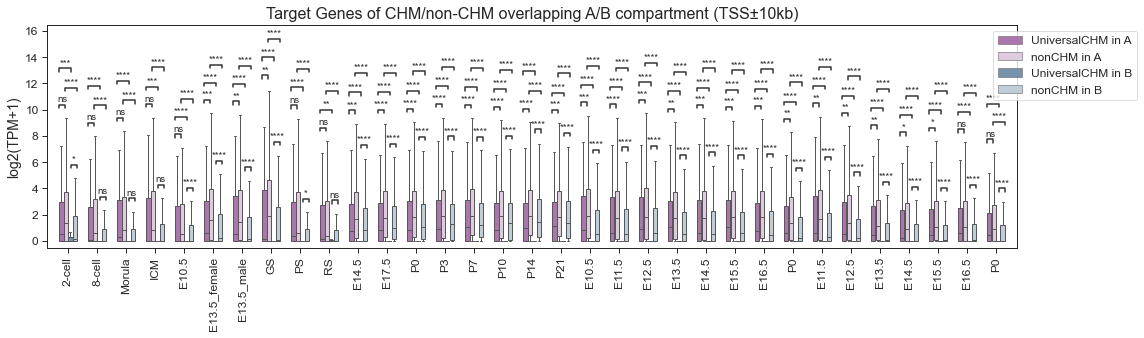

In [68]:
from statannot import add_stat_annotation

with sns.axes_style('white', rc={
        'xtick.bottom': True,
        'ytick.left': True
}), sns.plotting_context('paper',
                         rc={
                             'axes.titlesize': 16,
                             'axes.labelsize': 14,
                             'xtick.labelsize': 12,
                             'ytick.labelsize': 12,
                             'legend.fontsize': 12
                         }):
#     for distance in [10, 20, 50, 100] :
    for distance in [10] :
        df = plot_df_order_log2plus1.loc[(plot_df_order_log2plus1['distance'] == distance)]
        df['compart_ov_type'] = df['Type'] + ' in ' + df['compart']
        fig, ax = plt.subplots(figsize=(6.4 * 2.5, 4.8), tight_layout = True)
        sns.boxplot(
            data = df,
            y = 'log2(TPM+1)',
            x = 'Order',
            hue = 'compart_ov_type',
            hue_order = ['UniversalCHM in A', 'nonCHM in A', 'UniversalCHM in B', 'nonCHM in B'],
            showfliers = False, 
            palette = ['#B26EB5', '#E2C8E3', '#6E94B5', '#BBCDDC'],
            width = .618,
            linewidth = 1
        )
        add_stat_annotation(ax, data=df, x='Order', y='log2(TPM+1)', hue = 'compart_ov_type', hue_order = ['UniversalCHM in A', 'nonCHM in A', 'UniversalCHM in B', 'nonCHM in B'],
                        box_pairs=[((int(x.get_text()), 'UniversalCHM in A'), (int(x.get_text()), 'nonCHM in A')) for x in ax.get_xticklabels()] + 
                                  [((int(x.get_text()), 'UniversalCHM in A'), (int(x.get_text()), 'UniversalCHM in B')) for x in ax.get_xticklabels()] + 
                                  [((int(x.get_text()), 'nonCHM in A'), (int(x.get_text()), 'nonCHM in B')) for x in ax.get_xticklabels()] + 
                                  [((int(x.get_text()), 'UniversalCHM in B'), (int(x.get_text()), 'nonCHM in B')) for x in ax.get_xticklabels()],
                        test='Mann-Whitney', text_format='star', loc='inside', verbose=2)        
        ax.set_title(f'Target Genes of CHM/non-CHM overlapping A/B compartment (TSS±{distance}kb)')
        ax.set_xlabel('')
        ax.set_xticks(ax.get_xticks())
        ax.set_xticklabels(['_'.join(x.split('_')[1:]) for x in sample_order_df['sample']], rotation = 90, ha = 'center', va = 'top')
        h,l = ax.get_legend_handles_labels()
        ax.legend(h, l, title = '', loc = 'upper right', bbox_to_anchor = (1.13, 1))


        fig.savefig(f'/mnt/Storage/home/wangyiman/CHMsInOtherContexts/figures/make13_box_geneTPM_{distance}_compareCHMnonCHMAB_5tissue_consistent_pvalue.pdf', transparent = True)
        

## GO

do DAVID GO online  
use universal_CHM_Acompart, universal_CHM_Bcompart's target genes  
use non_CHM_Acompart, non_CHM_Bcompart's target genes  

### gene TSS with in 10kb

In [7]:
os.chdir('/mnt/Storage/home/wangyiman/CHMsInOtherContexts/CellStateTransition/CHMOrganization/Universal_specific/Features/ChromatinStates/Cavalli_Cell2017_ABcompartment_5tissue/CHM_intersect_table/targetGenes/DAVID_GO_10kb')
david_go_dict = {}
for compart in ['A', 'B'] :
    david_go_dict[compart] = {}
    df = csv_after_emptylines(f'GO_BP_cluster.UniversalCHM_{compart}.GO_BP_ALL.txt')
    df['GO Term'] = df['Term'].str.split('~', expand = True)[1]
    df['-log10(p-value)'] = -np.log10(df['PValue'].astype('float'))
    david_go_dict[compart] = df.loc[df['PValue'].astype('float') <= 0.05]

In [8]:
color_dict = {
    'A' : '#C490C6', 
    'B' : '#90ADC6'
}

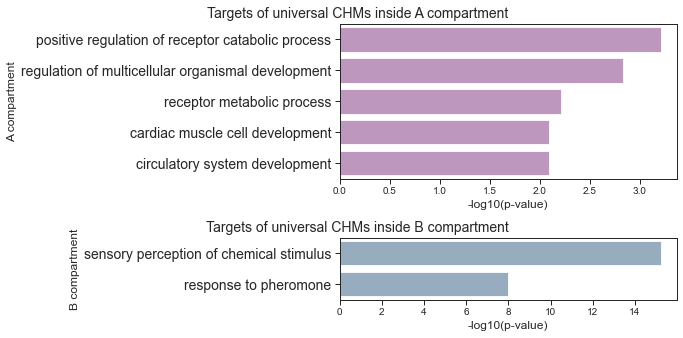

In [10]:
with sns.axes_style('white', rc={
        'xtick.bottom': True,
        'ytick.left': True
}), sns.plotting_context('paper',
                         rc={
                             'axes.titlesize': 14,
                             'axes.labelsize': 12,
                             'xtick.labelsize': 10,
                             'ytick.labelsize': 14,
                             'legend.fontsize': 10
                         }):
    fig, axes = plt.subplots(2,1,figsize = (6.4 * 1.5, 4.8), gridspec_kw={'height_ratios': [5,2]},
                             tight_layout= True, sharex=False)
    for i,compart in enumerate(['A', 'B']) :
        ax = axes[i]
#         for j,cell_type in enumerate(['intersect']) :
        df = david_go_dict[compart].sort_values(['-log10(p-value)'], ascending = False).groupby(['cluster']).head(1)
        if df.empty :
            break
        sns.barplot(
            data = df.head(5),
            y = 'GO Term',
            x = '-log10(p-value)',
            ax = ax,
            color = color_dict[compart]
        )
        ax.set_title(f'Targets of universal CHMs inside {compart} compartment', ha = 'right')
        ax.set_ylabel(f'{compart} compartment')
        
#     fig.savefig(f'/mnt/Storage/home/wangyiman/CHMsInOtherContexts/figures/make13_bar_GO_CHM_ABcompart_intersectAB_targets_5tissue_BP_ALL_consistent.pdf', transparent = True)    